In [3]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.ensemble
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

import xgboost

import random

In [15]:
######## Read data
#dataCSV = pd.read_csv("/home/gabija/Downloads/for_gabija.csv")   
#dataCSV = pd.read_csv("/home/gabija/Downloads/glialcell.csv")   
#dataCSV = pd.read_csv("greta/feature/macrophage.csv")   
dataCSV = pd.read_csv("greta/feature/T cell.csv")   
#dataCSV = pd.read_csv("greta/feature/B cell.csv")   

dataCSV = dataCSV.drop(columns=['rank_gwas_1', 'rank_tad', 'essentiality_ct'])

dataCSV = dataCSV.sort_values(by='first_year')

######## Prepare test and train datasets
data = pd.DataFrame(dataCSV)
X_meta = data.iloc[:,0:5]
X = data.iloc[:,6:]  #remove first descriptive cols
y = data["rank_pmid"]  #Predict rank_pmid
orig_year = data["orig_year"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [42]:
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
#X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 1000)

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [5]:
#a rather unfair RMSE
y_test_pred = model.predict(xgboost.DMatrix(X_test))
print('\nMean Square error" ', mean_squared_error(y_test,y_test_pred))

NameError: name 'model' is not defined

In [30]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
n=10000
shap.force_plot(explainer.expected_value, shap_values[n,:], X.iloc[n,:])#, matplotlib=True)

In [43]:
#### Check similarity between the samples (random subset)
randomlist = random.sample(range(0,shap_values.shape[0]), 3000)
shap.force_plot(explainer.expected_value, shap_values[randomlist], X.iloc[randomlist])

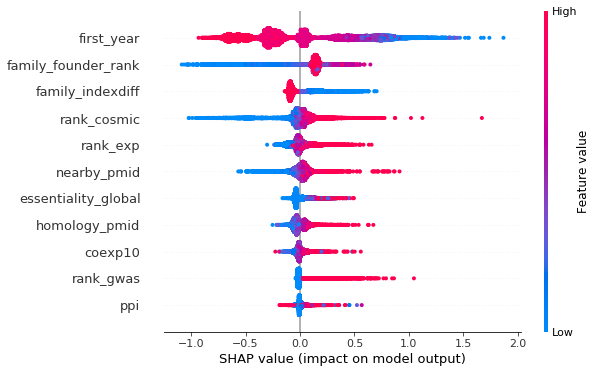

In [13]:
#Compare values
shap.summary_plot(shap_values, X)

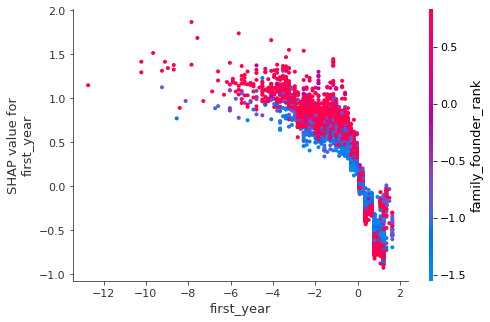

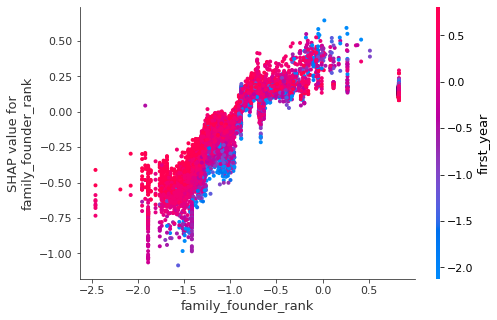

In [28]:
shap.dependence_plot("first_year", shap_values, X)
shap.dependence_plot("family_founder_rank", shap_values, X)
#shap.dependence_plot("rank_cosmic", shap_values, X)
#shap.dependence_plot("rank_gwas", shap_values, X)
#shap.dependence_plot("essentiality_global", shap_values, X)

In [6]:
# load JS visualization code to notebook
#shap.initjs()

# train XGBoost model
xlf = xgboost.XGBRegressor(objective="reg:squarederror", seed=1729)
xlf.fit(X_train, y_train, eval_metric='rmse', verbose = True, eval_set = [(X_test, y_test)])

# calculate the auc score
preds = xlf.predict(X_test)

print('\nMean Square error" ', mean_squared_error(y_test,preds))

[0]	validation_0-rmse:0.94834
[1]	validation_0-rmse:0.84662
[2]	validation_0-rmse:0.78746
[3]	validation_0-rmse:0.75389
[4]	validation_0-rmse:0.73591
[5]	validation_0-rmse:0.72535
[6]	validation_0-rmse:0.71853
[7]	validation_0-rmse:0.71370
[8]	validation_0-rmse:0.71184
[9]	validation_0-rmse:0.70925
[10]	validation_0-rmse:0.70625
[11]	validation_0-rmse:0.70651
[12]	validation_0-rmse:0.70630
[13]	validation_0-rmse:0.70693
[14]	validation_0-rmse:0.70765
[15]	validation_0-rmse:0.70760
[16]	validation_0-rmse:0.70801
[17]	validation_0-rmse:0.70789
[18]	validation_0-rmse:0.70782
[19]	validation_0-rmse:0.70849
[20]	validation_0-rmse:0.70874
[21]	validation_0-rmse:0.70884
[22]	validation_0-rmse:0.70845
[23]	validation_0-rmse:0.70937
[24]	validation_0-rmse:0.70928
[25]	validation_0-rmse:0.70938
[26]	validation_0-rmse:0.70927
[27]	validation_0-rmse:0.70839
[28]	validation_0-rmse:0.70847
[29]	validation_0-rmse:0.70593
[30]	validation_0-rmse:0.70517
[31]	validation_0-rmse:0.70507
[32]	validation_0-

0.5084195113917087


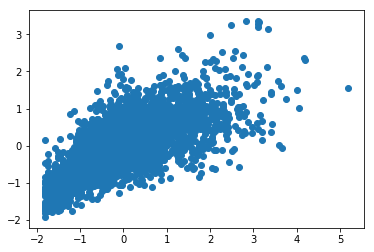

In [7]:
#################################################################
##Function: Get the prediction from some data, as numpy array
def predict_for(X):
    output = xlf.predict(X)
    return output

######## Plot predicted rank_pmid vs real rank_pmid
y_test_predicted = predict_for(X_test)
plt.scatter(y_test, y_test_predicted)  #X: real data, Y: predicted
print(mean_squared_error(y_test, y_test_predicted))

In [8]:
#### Sensitivity analysis
X_test_col = X_test.columns.tolist()
y_test_predicted = predict_for(X_test)
X_test_diff = X_test.copy()

outlist=[]

for i in range(0, len(X_test_col)):
    the_feature = X_test_col[i]
    #print(the_feature)
    X_test_perturb = X_test.copy()
    X_test_perturb[the_feature] = X_test_perturb + X_test[the_feature].std()
    y_test_perturbed_predicted = predict_for(X_test_perturb)
    
    X_test_diff[the_feature] = y_test_perturbed_predicted - y_test_predicted
    diff = ((y_test_perturbed_predicted - y_test_predicted)).mean()
    #print(diff)
    
    outlist.append(diff)

    
df = pd.DataFrame(list(zip(X_test_col, outlist)), 
               columns =['feature', 'val']) 
df = df.sort_values(by="val")
df.to_csv("plots/SimpleXG_out_weight.csv")
df

,feature,val
5,first_year,-0.275285
6,family_indexdiff,-0.029006
4,ppi,0.022275
9,rank_gwas,0.056276
1,coexp10,0.057157
10,homology_pmid,0.061250
3,nearby_pmid,0.078418
0,rank_exp,0.095128
2,essentiality_global,0.098240
8,rank_cosmic,0.144877


In [30]:
#X_test_col = X_test.columns.tolist()
y_all_predicted = predict_for(X)


y_all_predicted
X_meta["gene"].values.tolist()

#pd.DataFrame(dataCSV)
dictionary = dict(zip(X_meta["gene"].values.tolist(),y_all_predicted))
df= pd.DataFrame.from_dict(dictionary, orient='index')

#dictionary

df.to_csv("plots/xgboost.csv")
